In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial 3: Controlling Robot with Jacobian Fields.

Author: [Sizhe Lester Li](https://sizhe-li.github.io/), PhD Student, MIT CSAIL

## A. Learning Outcomes
In this tutorial, I will demonstrate how to do visual inverse dynamics control using Jacobian Fields 

## B. Pusher Environment Description

The environment contains a spherical robotic pusher. The robot can move freely in 2D space and is steered by a 2D velocity command $\delta u \triangleq (x, y)$, where $x, y \in \mathbb{R}$.


## BibTeX
Please consider citing our work if you find that our work is helpful for your research endeavors :D
```
@Article{Li2025,
  author={Li, Sizhe Lester
  and Zhang, Annan
  and Chen, Boyuan
  and Matusik, Hanna
  and Liu, Chao
  and Rus, Daniela
  and Sitzmann, Vincent},
  title={Controlling diverse robots by inferring Jacobian fields with deep networks},
  journal={Nature},
  year={2025},
  month={Jun},
  day={25},
  issn={1476-4687},
  doi={10.1038/s41586-025-09170-0},
  url={https://doi.org/10.1038/s41586-025-09170-0}
}
```


## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

# Load up the simulation environment

In [2]:
import os
from pathlib import Path

import mediapy as media
from hydra import compose, initialize
from jacobian.config.common import get_typed_root_config
from mujoco_sim.env.push_env import PushEnv, PushEnvCfg

overrides = []

map_to_sim_root = Path("../../mujoco-phys-sim")
config_path = Path("phys_sim/configurations/pusher_only.yaml")

with initialize(
    version_base=None, config_path=str(map_to_sim_root / config_path.parent)
):
    hydra_cfg = compose(
        config_name=str(config_path.name),
        overrides=overrides,
    )


env_cfg: PushEnvCfg = get_typed_root_config(hydra_cfg, PushEnvCfg)
env = PushEnv(env_cfg)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


WARNING! gymnasium is not installed. We will try to use openai gym instead.
Loading input MjModel


""

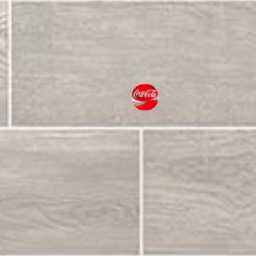

In [3]:
image = env.render("birdview")
media.show_image(image)

In [ ]:
import torch
import numpy as np

from jacobian.train import PipelineCfg
from jacobian.models.model_wrapper_base import get_wrapper

device = torch.device("cuda:0")

config_path = Path("project/jacobian/configurations/config.yaml")

# TODO: hard-coded
checkpoint_path = "./tutorial_pretrained_ckpts/zidq6tgi/model.ckpt"

model_name_kwrd = "unet_jacobian"

overrides = [
    "dataset=pusher_only",
    "wrapper=pusher_only",
]


with initialize(version_base=None, config_path=str("../../" / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

wrapper = get_wrapper(cfg.wrapper)
model = wrapper.model

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:
from jacobian.utils.wandb_ckpt import update_and_download_wandb_ckpt
checkpoint = torch.load(checkpoint_path)

msg = wrapper.load_state_dict(checkpoint["state_dict"], strict=False)
print(msg)

wrapper.eval()
wrapper.to(device)

print("finished loading model")

<All keys matched successfully>
finished loading model


### Implementing a trajectory tracker

1. **Converting a video into a "motion trajectory"**: we will use [cotrakcer](https://github.com/facebookresearch/co-tracker) for translating a video demonstration into a trajectory

2. **Trajectory tracking Details**. Please see Algorithm 1


""

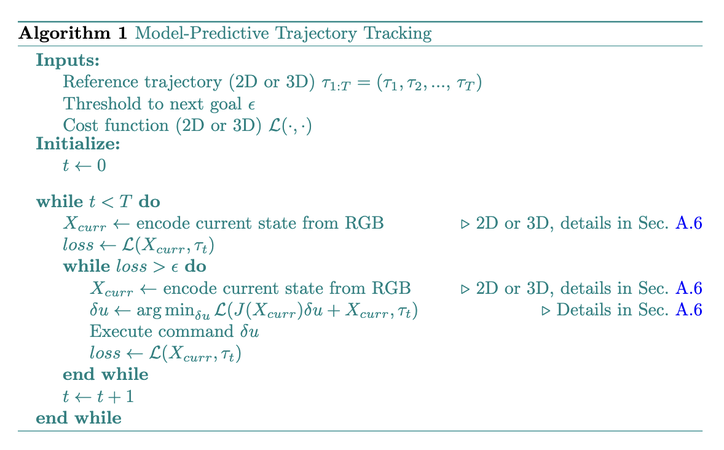

In [6]:
media.show_image(media.read_image("MPC_Tracking.png"), height=450)

In [7]:
import torch

cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker2").to(device)

Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_co-tracker_main


### Create a demonstration video

In [8]:
import numpy as np

traj_video = []
traj_qpos = []

def get_obs(env):
    image = env.render("birdview")
    qpos = env.data.get_body_xpos(f"pusher_main").copy()

    traj_video.append(image)
    traj_qpos.append(qpos)


# take a photo fo the mask
env.reset()
init_seg_mask = env.render("birdview", render_segmentation=True)

# reset and generate a traj.
env.reset()

position_based_command = np.array([0.0, -0.82])
horizon = 70
for i in range(horizon):
    env.step(position_based_command)

    if get_obs is not None:
        get_obs(env)

media.show_video(traj_video)

print(env.data.get_body_xpos(f"pusher_main").copy())
print(env.sim.data.get_joint_qpos("pusher_y_joint"))


[ 0.         -0.45999848  0.25      ]
-0.8199984902356017


### Translating the demonstration video to point tracks

In [9]:
from einops import rearrange

traj_video = np.stack(traj_video, axis=0)
traj_video_th = torch.from_numpy(traj_video).to(device).float()
traj_video_th = rearrange(traj_video_th, "t h w c -> () t c h w")

image_height, image_width = traj_video_th.shape[-2:]

init_seg_mask_th = torch.zeros(
    size=(image_height, image_width),
    dtype=torch.float32,
    device=device,
)

ids = init_seg_mask.copy()[..., 1]
for i in np.unique(ids):
    name: str = env.sim.model.geom_id2name(i)

    if "pusher" in name:
        init_seg_mask_th[ids == i] = 1.0

init_seg_mask_th = init_seg_mask_th.unsqueeze(0).unsqueeze(0)

cotracker_grid_size = 25

tracks, visibilities = cotracker(
    traj_video_th,
    segm_mask=init_seg_mask_th,
    grid_size=cotracker_grid_size,
    backward_tracking=False,
)

In [10]:
from cotracker.utils.visualizer import Visualizer

cotracker_visualizer = Visualizer(pad_value=0)

### Visualizing the point tracks

In [11]:
vis_video = cotracker_visualizer.visualize(
    video=traj_video_th,
    tracks=tracks,
    visibility=visibilities,
)[0]

vis_video = rearrange(vis_video, "t c h w -> t h w c")
vis_video = vis_video.cpu().numpy()

media.show_video(vis_video)

Video saved to ./results/video.mp4


### Visual Trajectory Tracking Using Jacobian Fields

In [12]:
def draw_curr_trgt_tracks(obs, curr_track, trgt_track, du_th):
    # draw desired motion, du
    canvas = obs.copy()
    for point_index in range(curr_track.shape[1]):
        point = curr_track[0, point_index]
        point = point.long().cpu().numpy()  # x, y

        desired_point = trgt_track[0, point_index]
        desired_point = desired_point.long().cpu().numpy()  # x

        x_start, y_start = point
        x_desired, y_desired = desired_point

        offset_scaled = du_th.detach().cpu().numpy() * vis_du_scale
        x_command, y_command = (point - offset_scaled.astype(float)).astype(int)

        canvas = cv2.arrowedLine(
            canvas,
            (x_start, y_start),
            (x_desired, y_desired),
            color=(0, 0, 0),
            thickness=2,
        )

        canvas = cv2.arrowedLine(
            canvas,
            (x_start, y_start),
            (x_command, y_command),
            color=(0, 225, 0),
            thickness=2,
            tipLength=0.3,
        )
    return canvas

In [13]:
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_online").to(device)


Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_co-tracker_main


In [ ]:
du_mult = 2.0
arrow_color = (0, 0, 0)
vis_du_scale = 20
du_to_command_scale = 0.1


In [21]:
import cv2
import tqdm
from jacobian.utils.io import numpy_to_torch_image

env.reset()

video = []
curr_track = tracks[:, 0].clone()  # 1 n xy
curr_visibl = visibilities[:, 0].clone()  # 1 n
trgt_track = tracks[:, -1].clone()  # 1 n xy

obs = env.render("birdview")
obs_th = numpy_to_torch_image(obs).float().unsqueeze(0)
obs_th = obs_th.to(device)

last_images = torch.stack([obs_th.clone() for _ in range(cotracker.step * 2)], dim=1)
prev_track = curr_track.clone()
# concatenate time to prev_track
time_tokens = torch.zeros_like(prev_track[..., :1])
queries = torch.cat([time_tokens, prev_track], dim=-1)

ran = tqdm.trange(50)

cotracker(video_chunk=last_images, is_first_step=True, queries=queries)

for step in ran:

    with torch.no_grad():
        jac_output = model.compute_jacobian(obs_th)

    v_desired = trgt_track - curr_track  # b x n x 2
    v_desired = v_desired[:, curr_visibl[0], :]
    curr_cost = v_desired.norm(dim=-1).mean()

    jac_output = jac_output[
        ...,
        curr_track[0, curr_visibl[0], 1].long(),
        curr_track[0, curr_visibl[0], 0].long(),
    ]
    jac_output = rearrange(
        jac_output,
        "() control_dim spatial_dim num_points -> (num_points spatial_dim) control_dim",
    )
    v_desired = rearrange(
        v_desired, "() num_points spatial_dim -> (num_points spatial_dim)"
    )
    du_th = torch.linalg.lstsq(jac_output, v_desired).solution

    canvas = draw_curr_trgt_tracks(
        obs,
        curr_track[:, curr_visibl[0], :],
        trgt_track[:, curr_visibl[0], :],
        du_th,
    )

    # append to video
    video.append(canvas)

    if curr_cost < 15:
        print("Task completed")
        break

    ran.set_description(f"Cost: {curr_cost.item()}")

    # take the action
    du_np = du_th.cpu().numpy()
    du_np[np.absolute(du_np) < 0.08] = 0.0

    robot_cmd = env.convert_local_command_to_global(du_np * du_mult)
    robot_cmd = robot_cmd.clip(-1.5, 1.5)

    for substep_index in range(1):
        env.step(robot_cmd)

    # update perceptual observations
    obs = env.render("birdview")
    obs_th = numpy_to_torch_image(obs).float().unsqueeze(0)
    obs_th = obs_th.to(device)

    # do tracking
    last_images = torch.cat([last_images[:, :-1], obs_th[:, None]], dim=1)

    pred_track, pred_visibl = cotracker(video_chunk=last_images)
    curr_track = pred_track[:, -1]  # 1 n xy
    curr_visibl = pred_visibl[:, -1]  # 1 n

    canvas = draw_curr_trgt_tracks(
        obs,
        curr_track[:, curr_visibl[0], :],
        trgt_track[:, curr_visibl[0], :],
        du_th,
    )
    video.append(canvas)

Cost: 69.5845718383789:   0%|          | 0/50 [00:00<?, ?it/s]

Cost: 15.786766052246094:  26%|██▌       | 13/50 [00:00<00:02, 16.87it/s]

Task completed


### Visualizing our control result!

Voila! We see that we are able to track the desired trajectory by repeatedly solving for the robot commands!

In [ ]:
media.show_video(video, fps=25)


: 